In [95]:
import numpy as np
import matplotlib.pyplot as plt
import sys

In [294]:
Lx, Ly = 4000e3, 4100e3
nx, ny = 500, 502
dx = Lx/nx
dy = Ly/ny

r0 = 6.378*10**6
day = 24*60*60 # length of day [seconds]
omega = 2*np.pi / day

g = 9.81
rho0 = 1025
f0 = 2*omega*np.sin(np.deg2rad(30))
beta_f = 2*omega*np.cos(np.deg2rad(30))/r0

In [295]:
xu_ocean = np.linspace(0,Lx,nx+1,dtype = float)
yu_ocean = np.linspace(0,Ly,ny+1,dtype = float)

xt_ocean = (xu_ocean[0:nx] + xu_ocean[1:nx+1])/2
yt_ocean = (yu_ocean[0:ny] + yu_ocean[1:ny+1])/2

Y,X = np.meshgrid(yt_ocean,xt_ocean)

## Ocean Parameters
1. Mixed layer depth is increased from $50m$ to $240m$ exponentially, as latitude increases.
2. Wind stress is increased from $0 N/m^2$ till $0.1 N/m^2$ at 40 degrees North, and follows a sine function.
3. Net surface heat flux is decreased from $50 W/m^2$ at 10 degrees north to $-50 W/m^2$ at 50 degrees north.
4. Thermal expansion coefficient is taken as $2.5 \times 10^{-4}$ degree $C^{-1}$.
5. Heat capacity of the ocean is taken as $4 \times 10^3 J/(kg C)$.
6. For simplicity, no subduction is allowed at the base of the mixed layer for now.

In [296]:
MLD_0 = -50*np.exp(1.57*Y/Ly)

#For double gyres
tau_x = (0.1*np.sin(np.pi*Y/(0.5*Ly) + 3*np.pi/2))

#For single gyre
#tau_x = (0.1*np.sin(np.pi*Y/(Ly) + 3*np.pi/2))

Qnet = 60*np.sin(np.pi*Y/Ly + np.pi/2)

<Figure size 432x288 with 0 Axes>

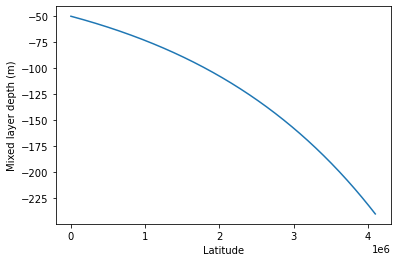

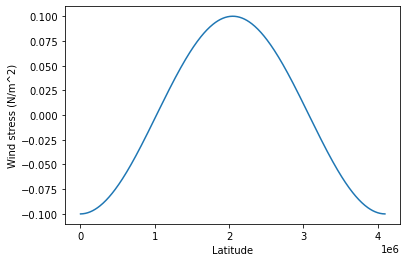

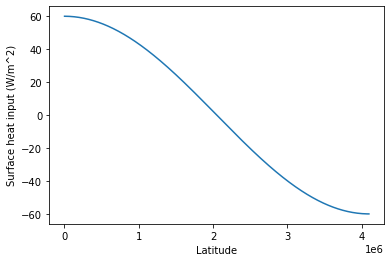

<Figure size 432x288 with 0 Axes>

In [297]:
plt.figure()
plt.plot(yt_ocean,MLD_0[0,:])
plt.xlabel('Latitude')
plt.ylabel('Mixed layer depth (m)')
plt.figure('Changes in mixed Layer depth with latitude')

plt.plot(yt_ocean,tau_x[0,:])
plt.xlabel('Latitude')
plt.ylabel('Wind stress (N/m^2)')
plt.figure('Changes in wind stress with latitude')

plt.plot(yt_ocean,Qnet[0,:])
plt.xlabel('Latitude')
plt.ylabel('Surface heat input (W/m^2)')
plt.figure('Changes in surface heat input with latitude')

In [298]:
#Thermal expansion coefficient = 3.2e-4(10 deg) -> 2e-4(50 deg)
alpha = 2.5e-4
#Salinity coefficient beta = 7.1e-4(10 deg) -> 7.5e-4(50 deg)
beta = 7.3e-4
#Heat capacity cp = 3.99e3(10 deg) -> 4.01e3(50 deg)
cp = 4e3

## Equations of Motion

In [302]:
dt = 200
t_start = 0
t_end = 20000
f = f0 + beta_f*(Y-Ly/2)
hm_old = -MLD_0
rhom_old = 1025*np.ones((nx,ny))
um_old = np.zeros((nx,ny))
um_new = np.zeros((nx,ny))
vm_old = np.zeros((nx,ny))
vm_new = np.zeros((nx,ny))
hm_new = np.zeros((nx,ny))
S05_old = np.zeros((nx,ny))
S05_new = np.zeros((nx,ny))
eta_old = np.zeros((nx,ny))
eta_new = np.zeros((nx,ny))
tau_y = np.zeros((nx,ny))
rhom_new = np.zeros((nx,ny))

In [303]:
def partial_x(f,dx):
    dfdx = 1/(2*dx) * (f[2:nx,1:ny-1] - f[0:nx-2,1:ny-1])
    return dfdx

def partial_y(f,dy):
    dfdy = 1/(2*dy) * (f[1:nx-1,2:ny] - f[1:nx-1,0:ny-2])
    return dfdy

def bnd_nostress(um_new,vm_new):
    um_new[0,0:ny] = 0
    um_new[nx-1,0:ny] = 0
    vm_new[0:nx,0] = 0
    vm_new[0:nx,ny-1] = 0
    
    vm_new[0,1:ny-1] = vm_new[1,1:ny-1]
    vm_new[nx-1,1:ny-1] = vm_new[nx-2,1:ny-1]
    um_new[1:nx-1,0] = um_new[1:nx-1,1]
    um_new[1:nx-1,ny-1] = um_new[1:nx-1,ny-2]
    
    return (um_new,vm_new)
    
def bnd_noslip(um_new,vm_new):
    
    um_new[0,0:ny] = 0
    um_new[nx-1,0:ny] = 0
    vm_new[0:nx,0] = 0
    vm_new[0:nx,ny-1] = 0
    
    vm_new[0,1:ny-1] = 0
    vm_new[nx-1,1:ny-1] = 0
    um_new[1:nx-1,0] = 0
    um_new[1:nx-1,ny-1] = 0
    
    return (um_new,vm_new)

def bnd_height_from_vel(hm_new,S05_old,um_old,vm_old,hm_old,dx,dy):
    hm_new[0,1:ny-1] = hm_old[0,1:ny-1] - (dt*S05_old[0,1:ny-1]) - vm_old[0,1:ny-1]*(
        dt/(2*dy))*(hm_old[0,2:ny] - hm_old[0,0:ny-2]) - hm_old[0,1:ny-1]*(
        dt/(2*dy))*(vm_old[0,2:ny] - vm_old[0,0:ny-2]) - hm_old[0,1:ny-1]*(
        dt/(2*dx))*(-3*um_old[0,1:ny-1] + 4*um_old[1,1:ny-1] - um_old[2,1:ny-1])
    hm_new[nx-1,1:ny-1] = hm_old[nx-1,1:ny-1] - (dt*S05_old[nx-1,1:ny-1]) - vm_old[nx-1,1:ny-1]*(
        dt/(2*dy))*(hm_old[nx-1,2:ny] - hm_old[nx-1,0:ny-2]) - hm_old[nx-1,1:ny-1]*(
        dt/(2*dy))*(vm_old[nx-1,2:ny] - vm_old[nx-1,0:ny-2]) - hm_old[nx-1,1:ny-1]*(
        dt/(2*dx))*(3*um_old[nx-1,1:ny-1] - 4*um_old[nx-2,1:ny-1] + um_old[nx-3,1:ny-1])
    hm_new[1:nx-1,0] = hm_old[1:nx-1,0] - (dt*S05_old[1:nx-1,0]) - um_old[1:nx-1,0]*(
        dt/(2*dx))*(hm_old[2:nx,0] - hm_old[0:nx-2,0]) - hm_old[1:nx-1,0]*(
        dt/(2*dx))*(um_old[2:nx,0] - um_old[0:nx-2,0]) - hm_old[1:nx-1,0]*(
        dt/(2*dy))*(-3*vm_old[1:nx-1,0] + 4*vm_old[1:nx-1,1] - vm_old[1:nx-1,2])
    hm_new[1:nx-1,ny-1] = hm_old[1:nx-1,ny-1] - (dt*S05_old[1:nx-1,ny-1]) - um_old[1:nx-1,ny-1]*(
        dt/(2*dx))*(hm_old[2:nx,ny-1] - hm_old[0:nx-2,ny-1]) - hm_old[1:nx-1,ny-1]*(
        dt/(2*dx))*(um_old[2:nx,ny-1] - um_old[0:nx-2,ny-1]) - hm_old[1:nx-1,ny-1]*(
        dt/(2*dy))*(3*vm_old[1:nx-1,ny-1] - 4*vm_old[1:nx-1,ny-2] + vm_old[1:nx-1,ny-3])
    
    hm_new[0,0] = hm_new[0,1]
    hm_new[nx-1,0] = hm_new[nx-1,1]
    hm_new[0,ny-1] = hm_new[0,ny-2]
    hm_new[nx-1,ny-1] = hm_new[nx-1,ny-2]
    
    return hm_new
    
def bnd_height_from_der(hm_new):
    hm_new[0,1:ny-1] = hm_new[1,1:ny-1]
    hm_new[nx-1,1:ny-1] = hm_new[nx-2,1:ny-1]
    hm_new[0:nx,0] = hm_new[0:nx,1]
    hm_new[0:nx,ny-1] = hm_new[0:nx,ny-2]
    
    return hm_new
    
def bnd_density_from_vel(rhom_new,rhom_old,S05_old,um_old,vm_old,hm_old,dx,dy,Qnet):
    rhom_new[0,1:ny-1] = rhom_old[0,1:ny-1] - ((dt*alpha*Qnet[0,1:ny-1])/(cp*hm_old[0,1:ny-1])) - (
        dt/(2*dy))*(rhom_old[0,2:ny] - rhom_old[0,0:ny-2])*vm_old[0,1:ny-1]
    rhom_new[nx-1,1:ny-1] = rhom_old[nx-1,1:ny-1] - ((dt*alpha*Qnet[nx-1,1:ny-1])/(cp*hm_old[nx-1,1:ny-1])) - (
        dt/(2*dy))*(rhom_old[nx-1,2:ny] - rhom_old[nx-1,0:ny-2])*vm_old[nx-1,1:ny-1]
    rhom_new[1:nx-1,ny-1] = rhom_old[1:nx-1,ny-1] - ((dt*alpha*Qnet[1:nx-1,ny-1])/(cp*hm_old[1:nx-1,ny-1])) - (
        dt/(2*dx))*(rhom_old[2:nx,ny-1] - rhom_old[0:nx-2,ny-1])*um_old[1:nx-1,ny-1]
    rhom_new[1:nx-1,0] = rhom_old[1:nx-1,0] - ((dt*alpha*Qnet[1:nx-1,0])/(cp*hm_old[1:nx-1,0])) - (
        dt/(2*dx))*(rhom_old[2:nx,0] - rhom_old[0:nx-2,0])*um_old[1:nx-1,0]
    
    rhom_new[0,0] = rhom_new[0,1]
    rhom_new[nx-1,0] = rhom_new[nx-1,1]
    rhom_new[0,ny-1] = rhom_new[0,ny-2]
    rhom_new[nx-1,ny-1] = rhom_new[nx-1,ny-2]
    
    return rhom_new
    
def bnd_density_from_der(rhom_new):
    rhom_new[0,1:ny-1] = rhom_new[1,1:ny-1]
    rhom_new[nx-1,1:ny-1] = rhom_new[nx-2,1:ny-1]
    rhom_new[0:nx,0] = rhom_new[0:nx,1]
    rhom_new[0:nx,ny-1] = rhom_new[0:nx,ny-2]
    
    return rhom_new

In [304]:
%%time

for t in np.arange(t_start,t_end+1,dt):
    
    Ft = (g/rho0)*(alpha*Qnet/cp)
    
    #Governing Equations
    
    hm_new[1:nx-1,1:ny-1] = hm_old[1:nx-1,1:ny-1] - dt*partial_x((um_old*hm_old),dx) - dt*partial_y(
        (vm_old*hm_old),dy) - dt*S05_old[1:nx-1,1:ny-1]
    
    if np.any(hm_new >= 300) or np.any(hm_new <= 30):
        exit('Mixed layer height is not in bounds')
                                                                 
    rhom_new[1:nx-1,1:ny-1] = rhom_old[1:nx-1,1:ny-1] - (dt*rho0/(g*hm_old[1:nx-1,1:ny-1]))*Ft[1:nx-1,1:ny-1] - (
        dt*um_old[1:nx-1,1:ny-1]*partial_x(rhom_old,dx)) - dt*vm_old[1:nx-1,1:ny-1]*partial_y(rhom_old,dy)
    
    if np.any(rhom_new >= 1050) or np.any(rhom_new <= 1000):
        exit('Density is not in bounds')

    um_new[1:nx-1,1:ny-1] = um_old[1:nx-1,1:ny-1] - dt*um_old[1:nx-1,1:ny-1]*partial_x(um_old,dx) - dt*vm_old[
        1:nx-1,1:ny-1]*partial_y(um_old,dy) + (dt*f[1:nx-1,1:ny-1]*vm_old[1:nx-1,1:ny-1]) - (
        g/(2*rho0))*dt*hm_old[1:nx-1,1:ny-1]*partial_x(rhom_old,dx) - (
        g/(rho0))*dt*rhom_old[1:nx-1,1:ny-1]*partial_x(eta_old,dx) + dt*(
        tau_x[1:nx-1,1:ny-1])/(rho0*hm_old[1:nx-1,1:ny-1])
    
    if np.any(um_new >= 15) or np.any(um_new <= -15):
        sys.exit("u velocity is not in bounds")
    
    vm_new[1:nx-1,1:ny-1] = vm_old[1:nx-1,1:ny-1] - dt*um_old[1:nx-1,1:ny-1]*partial_x(vm_old,dx) - (
        dt*vm_old[1:nx-1,1:ny-1]*partial_y(vm_old,dy) - (f[1:nx-1,1:ny-1]*dt*um_old[1:nx-1,1:ny-1]) - (
        (g*hm_old[1:nx-1,1:ny-1])/(2*rho0))*dt*partial_y(rhom_old,dy)) - ((g*rhom_old[
        1:nx-1,1:ny-1])/rho0)*dt*partial_y(eta_old,dy) + (dt*tau_y[1:nx-1,1:ny-1])/(rho0*hm_old[1:nx-1,1:ny-1])
    
    if np.any(vm_new >= 15) or np.any(vm_new <= -15):
        sys.exit("v velocity is not in bounds")
    
    
    #Boundary Conditions (I still need to think more about the 4 corner points for hm and rhom)
    
    #Better for coarse resolution models
    #bnd_nostress(um_new,vm_new)
    
    #Better for high resolution models
    bnd_noslip(um_new,vm_new)
    
    bnd_height_from_der(hm_new)
    bnd_density_from_der(rhom_new)

    #Updation Equations
    um_old = um_new
    vm_old = vm_new
    rhom_old = rhom_new
    hm_old = hm_new
    
    print(t/dt)

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0
CPU times: user 2.34 s, sys: 69.1 ms, total: 2.41 s
Wall time: 2.38 s


## Postprocessing
1. x-direction velocity is plotted, and three different regimes are visible.
2. Barotropic Streamfunction is calculated (needs more thought) and plotted.

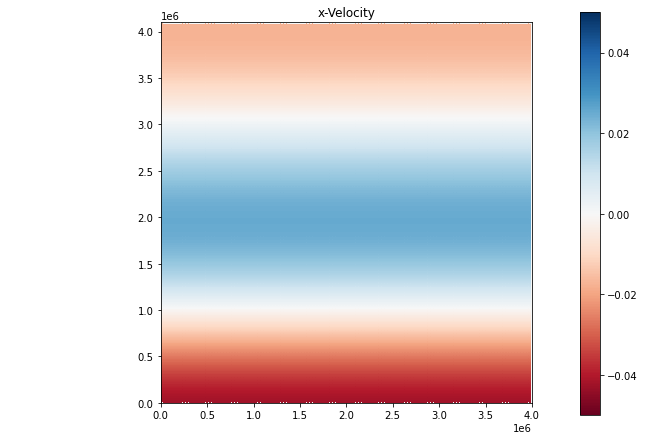

In [311]:
fig = plt.figure(figsize=(12, 7))

ax = fig.add_subplot(111)
ax.set_title('x-Velocity')
plt.pcolormesh(X, Y, um_new, shading = 'nearest', vmin = -0.05, vmax = 0.05, cmap = 'RdBu')
#plt.contourf(X,Y,um_new)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()

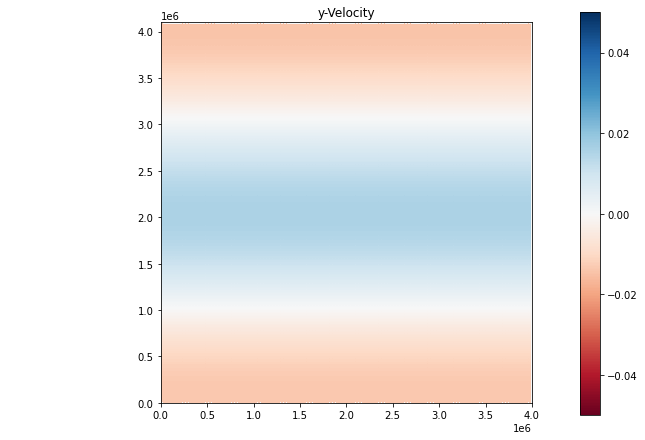

In [309]:
fig = plt.figure(figsize=(12, 7))

ax = fig.add_subplot(111)
ax.set_title('y-Velocity')
plt.pcolormesh(X, Y, vm_new, shading = 'nearest', vmin = -0.05, vmax = 0.05, cmap = 'RdBu')
#plt.contourf(X,Y,um_new)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()

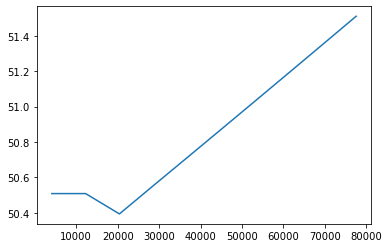

In [312]:
plt.plot(yt_ocean[0:10], hm_new[200,0:10])

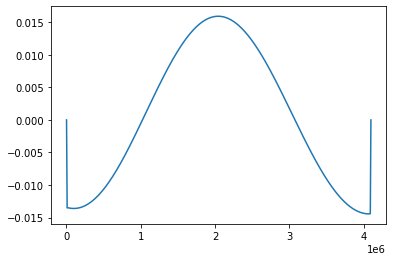

In [313]:
plt.plot(yt_ocean, vm_new[200,:])

In [ ]:
fig = plt.figure(figsize=(12, 7))

ax = fig.add_subplot(111)
ax.set_title('Density')
plt.pcolormesh(X, Y, rhom_new, shading = 'nearest', vmin = 1024.99, vmax = 1025.01)#, cmap = 'Greens')
#plt.contourf(X,Y,rhom_new)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()

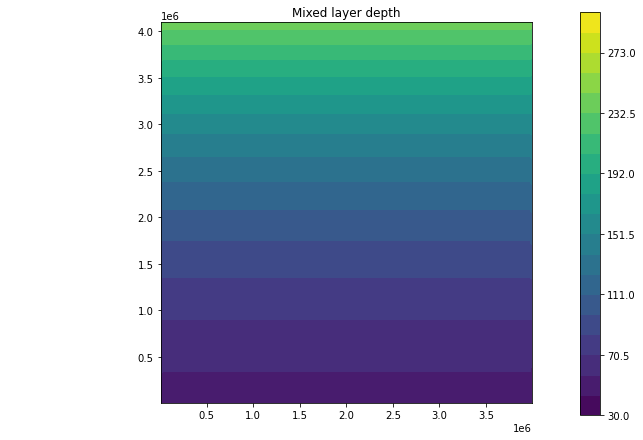

In [314]:
fig = plt.figure(figsize=(12, 7))

ax = fig.add_subplot(111)
ax.set_title('Mixed layer depth')
#plt.pcolormesh(X, Y, um_new, shading = 'nearest', vmin = -4e-2, vmax = 4e-2)#, cmap = 'Greens')
plt.contourf(X,Y,hm_new, levels = np.linspace(30,300,21))
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()

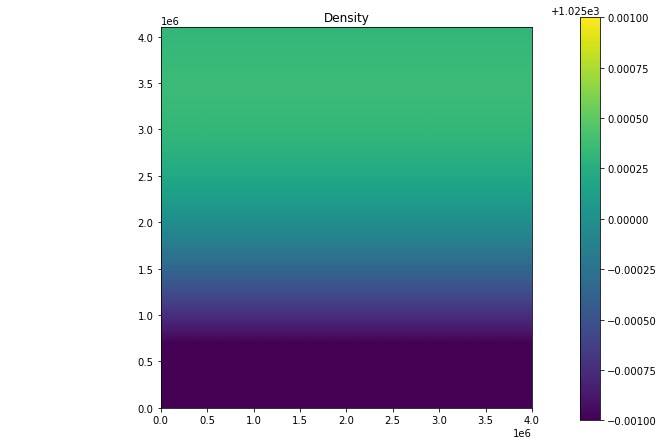

In [315]:
fig = plt.figure(figsize=(12, 7))

ax = fig.add_subplot(111)
ax.set_title('Density')
#plt.contourf(X,Y,rhom_new,cmap = 'RdBu_r')
plt.pcolormesh(X, Y, rhom_new, shading = 'nearest', vmin = 1024.999, vmax = 1025.001)#, cmap = 'Greens')
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()

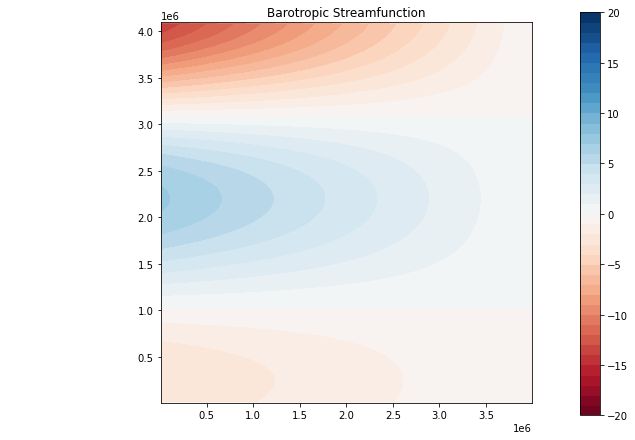

In [317]:
#This is correct if we integrate along the western boundary, where u = 0.
vm_flip = np.flip(vm_new,axis = 0)
hm_flip = np.flip(hm_new,axis = 0)
psi_flip = np.cumsum(vm_flip*hm_flip*dx,axis = 0)/10**6#*hm_new
psi_cor = np.flip(psi_flip,axis = 0)

fig = plt.figure(figsize=(12, 7))

ax = fig.add_subplot(111)
ax.set_title('Barotropic Streamfunction')
plt.contourf(X,Y,psi_cor,cmap = 'RdBu',levels = np.linspace(-20,20,41))
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()